In [1]:
import pandas as pd
import numpy as np


## Load data

In [2]:
new_df = pd.read_csv('POSfeatures.csv')

In [3]:
import random
random.seed(0)
samples= list(new_df.id.unique())
num_samples = len(samples)
train_ids = random.sample(samples,round(0.9*num_samples))
test_ids = list(set(samples)-set(train_ids))

df_train=pd.DataFrame()
for i in train_ids:
    df_train=df_train.append(new_df[new_df['id']==i])

df_test=pd.DataFrame()
for i in test_ids:
    df_test=df_test.append(new_df[new_df['id']==i])

X_train = df_train.drop('y',axis=1)
X_test = df_test.drop('y',axis=1)
y_train = df_train['y']
y_test = df_test['y']

In [4]:
new_df.id.unique()

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31],
      dtype=int64)

In [5]:
X_test = X_test.reset_index()
X_train = X_train.reset_index()

In [6]:
X_train.drop(['index'],inplace=True,axis=1)
X_test.drop(['index'],inplace=True,axis=1)

In [7]:
id_train = X_train.id
id_test = X_test.id

In [8]:
# def add_id(a):
#     return 'id'+str(a)

In [9]:
# X_train.id = X_train.id.apply(add_id) 
# X_test.id = X_test.id.apply(add_id) 

In [10]:
X_train.drop('id', axis=1, inplace=True)
X_test.drop('id', axis=1, inplace=True)

In [11]:
categorical_list = []
numerical_list = []
for i in X_train.columns.tolist():
    if (X_train[i].dtype=='object') or (X_train[i].dtype=='bool'):
        categorical_list.append(i)
    else:
        numerical_list.append(i)
print('Number of categorical features:', str(len(categorical_list)))
print('Number of numerical features:', str(len(numerical_list)))

Number of categorical features: 17
Number of numerical features: 34


In [12]:
categorical_list

['seq_01',
 'seq_02',
 'seq_03',
 'is_past_tense',
 'is_modal',
 'first_tag',
 'second_tag',
 'third_tag',
 'exists_she',
 'exists_he',
 'first_word_is_the',
 'first_word_is_she',
 'first_word_is_he',
 'first_word_is_it',
 'first_word_is_this',
 'first_word_is_you',
 'first_word_is_OK']

In [13]:
from sklearn.preprocessing import OneHotEncoder, StandardScaler
# Instantiate encoder/scaler
scaler = StandardScaler()
ohe    = OneHotEncoder(sparse=False,drop='if_binary')

# Scale and Encode Separate Columns
scaled_columns  = pd.DataFrame(scaler.fit_transform(X_train[numerical_list]), columns = X_train[numerical_list].columns)
encoded_columns =    pd.DataFrame(ohe.fit_transform(X_train[categorical_list]), columns =ohe.get_feature_names(categorical_list))

# Concatenate (Column-Bind) Processed Columns Back Together
X_train = pd.concat([scaled_columns.reset_index(), encoded_columns.reset_index()], axis=1)
X_train.drop(['index','index'], inplace=True,axis=1)

In [14]:
scaled_columns  = pd.DataFrame(scaler.transform(X_test[numerical_list]), columns = X_test[numerical_list].columns)
encoded_columns =    pd.DataFrame(ohe.transform(X_test[categorical_list]), columns =ohe.get_feature_names(categorical_list))

# Concatenate (Column-Bind) Processed Columns Back Together
X_test = pd.concat([scaled_columns.reset_index(), encoded_columns.reset_index()], axis=1)
X_test.drop(['index','index'], inplace=True,axis=1)

In [18]:
X_train['question']

KeyError: 'question'

In [16]:
df_train = X_train.copy()
df_train['y'] = y_train.values

In [17]:
df_train.isna().sum().sum()

0

In [119]:
# X_train.drop('id', axis=1, inplace=True)
# X_test.drop('id', axis=1, inplace=True)

## Feature selection

### null importance

In [31]:
# df_train = X_train.copy()
# y_trai
df_train['y'] = y_train.values

In [7]:
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import KFold
import time
from lightgbm import LGBMClassifier
import lightgbm as lgb

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns
%matplotlib inline

import warnings
warnings.simplefilter('ignore', UserWarning)

import gc
gc.enable()

In [ ]:
data = df_train.copy()



# categorical_feats = df_train.columns[[-1,-2,-3]]

# print(categorical_feats)
# for f_ in categorical_feats:
#     data[f_], _ = pd.factorize(data[f_])
#     # Set feature type as categorical
#     data[f_] = data[f_].astype('category')

In [ ]:
data

,timestamp,confidence,gaze_0_x,gaze_0_y,gaze_0_z,gaze_1_x,gaze_1_y,gaze_1_z,gaze_angle_x,gaze_angle_y,...,AU26_c,AU28_c,AU45_c,question,person_id,WC,OtherP,y,positive_assumption,negative_assumption
6415,0.000000,0.98,0.326309,0.274022,-0.904674,0.158873,0.243419,-0.956821,0.255,0.271,...,0,0,0,1,28,119,0.0,0,0,0
6416,0.040000,0.98,0.336460,0.274016,-0.900949,0.161493,0.241291,-0.956922,0.262,0.271,...,0,0,0,1,28,119,0.0,0,0,0
6417,0.080000,0.98,0.341593,0.269892,-0.900263,0.166425,0.237461,-0.957035,0.267,0.267,...,0,0,0,1,28,119,0.0,0,0,0
6418,0.120000,0.98,0.341751,0.269591,-0.900292,0.166547,0.237231,-0.957070,0.267,0.266,...,0,0,0,1,28,119,0.0,0,0,0
6419,0.160000,0.98,0.341803,0.269438,-0.900319,0.166416,0.237016,-0.957146,0.267,0.266,...,0,0,0,1,28,119,0.0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
860059,44.320000,0.98,0.191839,0.410695,-0.891362,0.040223,0.424845,-0.904372,0.129,0.435,...,1,0,0,24,24,100,0.0,1,0,0
860060,44.360001,0.98,0.189389,0.405606,-0.894212,0.039152,0.419084,-0.907103,0.126,0.429,...,1,0,0,24,24,100,0.0,1,0,0
860061,44.400002,0.98,0.187418,0.443895,-0.876260,0.030524,0.459217,-0.887799,0.123,0.473,...,0,0,0,24,24,100,0.0,1,0,0
860062,44.439999,0.93,0.186500,0.458894,-0.868697,0.029780,0.475174,-0.879388,0.123,0.491,...,0,0,0,24,24,100,0.0,1,0,0


In [ ]:
def get_feature_importances(data, shuffle, seed=None):
    # Gather real features
    train_features = [f for f in data if f not in ['y', 'question','WC','positive_assumption','negative_assumption']]
    # Go over fold and keep track of CV score (train and valid) and feature importances
    
    # Shuffle target if required
    y = data['y'].copy()
    if shuffle:
        # Here you could as well use a binomial distribution
        y = data['y'].copy().sample(frac=1.0)
    
    # Fit LightGBM in RF mode, yes it's quicker than sklearn RandomForest
    dtrain = lgb.Dataset(data[train_features], y, free_raw_data=False, silent=True)
    lgb_params = {
        'objective': 'binary',
        'boosting_type': 'rf',
        'subsample': 0.623,
        'colsample_bytree': 0.7,
        'num_leaves': 127,
        'max_depth': 8,
        'seed': seed,
        'bagging_freq': 1,
        'n_jobs': 4
    }
    
    # Fit the model
    clf = lgb.train(params=lgb_params, train_set=dtrain, num_boost_round=200)

    # Get feature importances
    imp_df = pd.DataFrame()
    imp_df["feature"] = list(train_features)
    imp_df["importance_gain"] = clf.feature_importance(importance_type='gain')
    imp_df["importance_split"] = clf.feature_importance(importance_type='split')
    imp_df['trn_score'] = roc_auc_score(y, clf.predict(data[train_features]))
    
    return imp_df

In [ ]:
np.random.seed(123)
# Get the actual importance, i.e. without shuffling
actual_imp_df = get_feature_importances(data=data, shuffle=False)

[LightGBM] [Info] Number of positive: 421357, number of negative: 366120
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 2.064860 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 176490
[LightGBM] [Info] Number of data points in the train set: 787477, number of used features: 713
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.535072 -> initscore=0.140519
[LightGBM] [Info] Start training from score 0.140519
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with posit

In [ ]:
actual_imp_df.trn_score.unique()

array([0.72580373])

In [ ]:
null_imp_df = pd.DataFrame()
nb_runs = 80
import time
start = time.time()
dsp = ''
for i in range(nb_runs):
    # Get current run importances
    imp_df = get_feature_importances(data=data, shuffle=True)
    imp_df['run'] = i + 1 
    # Concat the latest importances with the old ones
    null_imp_df = pd.concat([null_imp_df, imp_df], axis=0)
    # Erase previous message
    for l in range(len(dsp)):
        print('\b', end='', flush=True)
    # Display current run and time used
    spent = (time.time() - start) / 60
    dsp = 'Done with %4d of %4d (Spent %5.1f min)' % (i + 1, nb_runs, spent)
    print(dsp, end='', flush=True)

[LightGBM] [Info] Number of positive: 421357, number of negative: 366120
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 2.049123 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 176490
[LightGBM] [Info] Number of data points in the train set: 787477, number of used features: 713
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.535072 -> initscore=0.140519
[LightGBM] [Info] Start training from score 0.140519
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with posit

KeyboardInterrupt: 

In [ ]:
null_imp_df.head()

In [ ]:
def display_distributions(actual_imp_df_, null_imp_df_, feature_):
    plt.figure(figsize=(13, 6))
    gs = gridspec.GridSpec(1, 2)
    # Plot Split importances
    ax = plt.subplot(gs[0, 0])
    a = ax.hist(null_imp_df_.loc[null_imp_df_['feature'] == feature_, 'importance_split'].values, label='Null importances')
    ax.vlines(x=actual_imp_df_.loc[actual_imp_df_['feature'] == feature_, 'importance_split'].mean(), 
               ymin=0, ymax=np.max(a[0]), color='r',linewidth=10, label='Real Target')
    ax.legend()
    ax.set_title('Split Importance of %s' % feature_.upper(), fontweight='bold')
    plt.xlabel('Null Importance (split) Distribution for %s ' % feature_.upper())
    # Plot Gain importances
    ax = plt.subplot(gs[0, 1])
    a = ax.hist(null_imp_df_.loc[null_imp_df_['feature'] == feature_, 'importance_gain'].values, label='Null importances')
    ax.vlines(x=actual_imp_df_.loc[actual_imp_df_['feature'] == feature_, 'importance_gain'].mean(), 
               ymin=0, ymax=np.max(a[0]), color='r',linewidth=10, label='Real Target')
    ax.legend()
    ax.set_title('Gain Importance of %s' % feature_.upper(), fontweight='bold')
    plt.xlabel('Null Importance (gain) Distribution for %s ' % feature_.upper())

In [ ]:
display_distributions(actual_imp_df_=actual_imp_df, null_imp_df_=null_imp_df, feature_='LIVINGAPARTMENTS_AVG')

In [ ]:
feature_scores = []
for _f in actual_imp_df['feature'].unique():
    f_null_imps_gain = null_imp_df.loc[null_imp_df['feature'] == _f, 'importance_gain'].values
    f_act_imps_gain = actual_imp_df.loc[actual_imp_df['feature'] == _f, 'importance_gain'].mean()
    gain_score = np.log(1e-10 + f_act_imps_gain / (1 + np.percentile(f_null_imps_gain, 75)))  # Avoid didvide by zero
    f_null_imps_split = null_imp_df.loc[null_imp_df['feature'] == _f, 'importance_split'].values
    f_act_imps_split = actual_imp_df.loc[actual_imp_df['feature'] == _f, 'importance_split'].mean()
    split_score = np.log(1e-10 + f_act_imps_split / (1 + np.percentile(f_null_imps_split, 75)))  # Avoid didvide by zero
    feature_scores.append((_f, split_score, gain_score))

scores_df = pd.DataFrame(feature_scores, columns=['feature', 'split_score', 'gain_score'])

plt.figure(figsize=(16, 16))
gs = gridspec.GridSpec(1, 2)
# Plot Split importances
ax = plt.subplot(gs[0, 0])
sns.barplot(x='split_score', y='feature', data=scores_df.sort_values('split_score', ascending=False).iloc[0:70], ax=ax)
ax.set_title('Feature scores wrt split importances', fontweight='bold', fontsize=14)
# Plot Gain importances
ax = plt.subplot(gs[0, 1])
sns.barplot(x='gain_score', y='feature', data=scores_df.sort_values('gain_score', ascending=False).iloc[0:70], ax=ax)
ax.set_title('Feature scores wrt gain importances', fontweight='bold', fontsize=14)
plt.tight_layout()




### Correlation

In [19]:
application_sample1 = df_train.loc[df_train.y==1].sample(frac=1, replace=False)
print('label 1 sample size:', str(application_sample1.shape[0]))
application_sample0 = df_train.loc[df_train.y==0].sample(frac=1, replace=False)
print('label 0 sample size:', str(application_sample0.shape[0]))
application = pd.concat([application_sample1, application_sample0], axis=0)

label 1 sample size: 417
label 0 sample size: 393


In [20]:
categorical_list = []
numerical_list = []
for i in application.columns.tolist():
    if application[i].dtype=='object':
        categorical_list.append(i)
    else:
        numerical_list.append(i)
print('Number of categorical features:', str(len(categorical_list)))
print('Number of numerical features:', str(len(numerical_list)))

Number of categorical features: 0
Number of numerical features: 124


In [21]:
# from sklearn.impute import SimpleImputer
# application[numerical_list] = SimpleImputer(strategy='median').fit_transform(application[numerical_list])

In [22]:
X = application.drop(['y'], axis=1)
y = application.y
feature_name = X.columns.tolist()

In [23]:
def cor_selector(X, y):
    cor_list = []
    # calculate the correlation with y for each feature
    for i in X.columns.tolist():
        cor = np.corrcoef(X[i], y)[0, 1]
        cor_list.append(cor)
    # replace NaN with 0
    cor_list = [0 if np.isnan(i) else i for i in cor_list]
    # feature name
    cor_feature = X.iloc[:,np.argsort(np.abs(cor_list))[-100:]].columns.tolist()
    # feature selection? 0 for not select, 1 for select
    cor_support = [True if i in cor_feature else False for i in feature_name]
    return cor_support, cor_feature

In [24]:
cor_support, cor_feature = cor_selector(X, y)
print(str(len(cor_feature)), 'selected features')
print(cor_feature)

100 selected features
['second_tag_False', 'count_3rd person', 'second_tag_IN', 'first_tag_NN', 'first_word_is_this_True', 'second_tag_CC', 'second_tag_EX', 'first_tag_WRB', 'third_tag_WDT', 'first_tag_WP', 'third_tag_IN', "third_tag_''", 'second_tag_VBG', 'first_tag_IN', 'first_tag_NNP', 'third_tag_CC', 'second_tag_NNS', 'count_PDT', 'count_DT', 'third_tag_VBP', 'second_tag_.', 'count_of_fillers', 'second_tag_VBZ', 'first_tag_DT', 'first_tag_PRP$', 'second_tag_POS', 'third_tag_VBN', 'third_tag_CD', 'third_tag_PRP$', 'third_tag_VB', 'first_tag_VBD', 'third_tag_RBS', 'second_tag_PRP', 'third_tag_VBD', 'third_tag_UH', 'first_word_is_he_True', 'second_tag_PDT', 'third_tag_EX', 'third_tag_NNS', 'second_tag_PRP$', 'second_tag_DT', 'third_tag_RBR', 'first_tag_EX', 'second_tag_MD', 'first_tag_PRP', 'third_tag_NN', 'third_tag_WRB', 'count_NNP', 'count_LS', 'second_tag_VBD', 'first_tag_JJR', 'first_tag_VBP', 'second_tag_WRB', 'third_tag_WP', 'count_NNS', 'seq_02_True', 'third_tag_POS', 'third_t

C:\ProgramData\Anaconda3\lib\site-packages\numpy\lib\function_base.py:2691: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
C:\ProgramData\Anaconda3\lib\site-packages\numpy\lib\function_base.py:2692: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]





### chi


In [101]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
from sklearn.preprocessing import MinMaxScaler
X_norm = MinMaxScaler().fit_transform(X_train)
chi_selector = SelectKBest(chi2, k=100)
chi_selector.fit(X_train.abs(), y_train)

SelectKBest(k=100, score_func=<function chi2 at 0x000001EEA67375E0>)

In [103]:

chi_support = chi_selector.get_support()
chi_feature = X_train.loc[:,chi_support].columns.tolist()
print(str(len(chi_feature)), 'selected features')

100 selected features


### RFE

In [117]:
from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression
rfe_selector = RFE(estimator=LogisticRegression(), n_features_to_select=100, step=1500, verbose=5)
rfe_selector.fit(X_train, y_train)


Fitting estimator with 50080 features.
Fitting estimator with 48580 features.
Fitting estimator with 47080 features.
Fitting estimator with 45580 features.
Fitting estimator with 44080 features.
Fitting estimator with 42580 features.
Fitting estimator with 41080 features.
Fitting estimator with 39580 features.
Fitting estimator with 38080 features.
Fitting estimator with 36580 features.
Fitting estimator with 35080 features.
Fitting estimator with 33580 features.
Fitting estimator with 32080 features.
Fitting estimator with 30580 features.
Fitting estimator with 29080 features.
Fitting estimator with 27580 features.
Fitting estimator with 26080 features.
Fitting estimator with 24580 features.
Fitting estimator with 23080 features.
Fitting estimator with 21580 features.
Fitting estimator with 20080 features.
Fitting estimator with 18580 features.
Fitting estimator with 17080 features.
Fitting estimator with 15580 features.
Fitting estimator with 14080 features.
Fitting estimator with 12

RFE(estimator=LogisticRegression(), n_features_to_select=100, step=1500,
    verbose=5)

In [133]:
rfe_support = rfe_selector.get_support()
rfe_feature = X_train.loc[:,rfe_support].columns.tolist()
print(str(len(rfe_feature)), 'selected features')

100 selected features


### SelectFromModel

In [149]:
from sklearn.feature_selection import SelectFromModel
from sklearn.linear_model import LogisticRegression

embeded_lr_selector = SelectFromModel(LogisticRegression(penalty="l2"), '1.25*median')
embeded_lr_selector.fit(X_train, y_train)

embeded_lr_support = embeded_lr_selector.get_support()
embeded_lr_feature = X_train.loc[:,embeded_lr_support].columns.tolist()
print(str(len(embeded_lr_feature)), 'selected features')

19788 selected features


### SelectFromRF

In [150]:
from sklearn.feature_selection import SelectFromModel
from sklearn.ensemble import RandomForestClassifier

embeded_rf_selector = SelectFromModel(RandomForestClassifier(n_estimators=100), threshold='1.25*median')
embeded_rf_selector.fit(X_train, y_train)

embeded_rf_support = embeded_rf_selector.get_support()
embeded_rf_feature = X_train.loc[:,embeded_rf_support].columns.tolist()
print(str(len(embeded_rf_feature)), 'selected features')

50080 selected features


### SelectFromlgbm

In [151]:
from sklearn.feature_selection import SelectFromModel
from lightgbm import LGBMClassifier

lgbc=LGBMClassifier(n_estimators=500, learning_rate=0.05, num_leaves=32, colsample_bytree=0.2,
            reg_alpha=3, reg_lambda=1, min_split_gain=0.01, min_child_weight=40)

embeded_lgb_selector = SelectFromModel(lgbc, threshold='1.25*median')
embeded_lgb_selector.fit(X_train, y_train)

embeded_lgb_support = embeded_lgb_selector.get_support()
embeded_lgb_feature = X_train.loc[:,embeded_lgb_support].columns.tolist()
print(str(len(embeded_lgb_feature)), 'selected features')

50080 selected features


# Models correlation features

In [25]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn import svm
from sklearn import tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import StandardScaler
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score
from sklearn.feature_selection import SelectFromModel

from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
%matplotlib inline
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D



import warnings
warnings.filterwarnings('ignore')

In [26]:
features = X_train[cor_feature]
features2 = X_test[cor_feature]

In [27]:
features.isna().sum().sum()

0

In [28]:
y_train

27     1.0
58     0.0
89     1.0
120    0.0
151    1.0
      ... 
761    0.0
792    1.0
823    0.0
854    1.0
884    0.0
Name: y, Length: 810, dtype: float64

In [29]:
from sklearn.model_selection import cross_val_score
# from sklearn.datasets import load_iris
from sklearn.ensemble import AdaBoostClassifier

# X, y = load_iris(return_X_y=True)
clf = AdaBoostClassifier()
# scores = cross_val_score(clf, features, y_train, cv=5)
# print(scores.mean())
clf.fit(features, y_train)
y_pred = (clf.predict(features2)>0.5).astype(int)
from sklearn.metrics import classification_report
print(classification_report(y_pred,y_test))


              precision    recall  f1-score   support

           0       0.47      0.57      0.51        37
           1       0.62      0.52      0.57        50

    accuracy                           0.54        87
   macro avg       0.54      0.54      0.54        87
weighted avg       0.55      0.54      0.54        87



In [30]:
from sklearn.svm import SVC

svclassifier = SVC(gamma='auto')
svclassifier.fit(features, y_train)
y_pred = svclassifier.predict(features2)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

         0.0       0.51      0.40      0.45        45
         1.0       0.48      0.60      0.53        42

    accuracy                           0.49        87
   macro avg       0.50      0.50      0.49        87
weighted avg       0.50      0.49      0.49        87



In [31]:
from sklearn import datasets
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from itertools import product
from sklearn.ensemble import VotingClassifier


clf1 = DecisionTreeClassifier()
clf2 = KNeighborsClassifier()
clf3 = SVC(kernel='rbf', probability=True)
eclf = VotingClassifier(estimators=[('dt', clf1), ('knn', clf2), ('svc', clf3)],
                        voting='soft', weights=[2, 2, 2])

clf1 = clf1.fit(features, y_train)
clf2 = clf2.fit(features, y_train)
clf3 = clf3.fit(features, y_train)
eclf = eclf.fit(features, y_train)

for clf, label in zip([clf1, clf2, clf3, eclf], ['DecisionTreeClassifier', 'KNNClassifier', 'SVC', 'voting']):
    scores = cross_val_score(clf, features, y_train, scoring='accuracy', cv=5)
    print("Accuracy: %0.2f (+/- %0.2f) [%s]" % (scores.mean(), scores.std(), label))

Accuracy: 0.54 (+/- 0.04) [DecisionTreeClassifier]
Accuracy: 0.56 (+/- 0.03) [KNNClassifier]
Accuracy: 0.58 (+/- 0.03) [SVC]
Accuracy: 0.55 (+/- 0.01) [voting]


In [32]:
svc = SVC(kernel='rbf', probability=True,)
svc.fit(features, y_train)
predictionsSVC = svc.predict(features2)
scoreSVC = accuracy_score(y_test, predictionsSVC)
print(f"Support Vector Classifier score is {scoreSVC * 100}%\n")
print(classification_report(y_test, predictionsSVC))

Support Vector Classifier score is 49.42528735632184%

              precision    recall  f1-score   support

         0.0       0.52      0.38      0.44        45
         1.0       0.48      0.62      0.54        42

    accuracy                           0.49        87
   macro avg       0.50      0.50      0.49        87
weighted avg       0.50      0.49      0.49        87



In [33]:
# g = [0.001*x for x in range(1,10,1)]

# for g1 in g:
#     svc = SVC(kernel='rbf', probability=True,gamma=g1)
#     svc.fit(features, y_train)
#     predictionsSVC = svc.predict(features2)
# #     scoreSVC = accuracy_score(y_test, predictionsSVC)
# #     print(f"Support Vector Classifier score is {scoreSVC * 100}%\n")
#     print(g1,classification_report(y_test, predictionsSVC))

In [34]:
# c1= [0.001*x for x in range(560,650)]

# for c in c1:
#     svc = SVC(kernel='rbf', probability=True,gamma=0.004,C=c)
#     svc.fit(features, y_train)
#     predictionsSVC = svc.predict(features2)
#     print(c,classification_report(y_test, predictionsSVC))

In [35]:
svc = SVC(kernel='rbf', probability=True)
svc.fit(features, y_train)
predictionsSVC = svc.predict(features2)
print(classification_report(y_test, predictionsSVC))

              precision    recall  f1-score   support

         0.0       0.52      0.38      0.44        45
         1.0       0.48      0.62      0.54        42

    accuracy                           0.49        87
   macro avg       0.50      0.50      0.49        87
weighted avg       0.50      0.49      0.49        87



Logistic Regression score is 50.57471264367817% 

Support Vector Classifier score is 50.57471264367817%

Decision Tree Classifier score is 47.12643678160919%

Random Forest Classifier score is 50.57471264367817%

KNN Classifier score is 44.827586206896555% with k = 1
KNN Classifier score is 47.12643678160919% with k = 2
KNN Classifier score is 55.172413793103445% with k = 3
KNN Classifier score is 55.172413793103445% with k = 4
KNN Classifier score is 52.87356321839081% with k = 5
KNN Classifier score is 54.02298850574713% with k = 6
KNN Classifier score is 51.724137931034484% with k = 7
KNN Classifier score is 52.87356321839081% with k = 8
KNN Classifier score is 49.42528735632184% with k = 9
KNN Classifier score is 54.02298850574713% with k = 10
KNN Classifier score is 48.275862068965516% with k = 11
KNN Classifier score is 51.724137931034484% with k = 12
KNN Classifier score is 56.32183908045977% with k = 13
KNN Classifier score is 57.47126436781609% with k = 14
KNN Classifier score

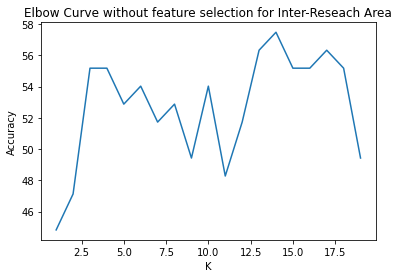


MLP Classifier score is 48.275862068965516%



In [36]:
# fitting logistic regression
lr = LogisticRegression()
lr.fit(features, y_train)
predictionsLR = lr.predict(features2)
scoreLR = accuracy_score(y_test, predictionsLR)
print(f"Logistic Regression score is {scoreLR * 100}% \n")

# fitting SVC
svc = svm.LinearSVC()
svc.fit(features, y_train)
predictionsSVC = svc.predict(features2)
scoreSVC = accuracy_score(y_test, predictionsSVC)
print(f"Support Vector Classifier score is {scoreSVC * 100}%\n")

# fitting decision tree classifier
clf = tree.DecisionTreeClassifier()
clf.fit(features, y_train)
predictionsTree = clf.predict(features2)
scoreTree = accuracy_score(y_test, predictionsTree)
print(f"Decision Tree Classifier score is {scoreTree * 100}%\n")

# fitting Random Forest classifier
clf1 = RandomForestClassifier()
clf1.fit(features, y_train)
predictionsTree1 = clf1.predict(features2)
scoreTree1 = accuracy_score(y_test, predictionsTree1)
print(f"Random Forest Classifier score is {scoreTree1 * 100}%\n")

# fitting XGBoost
# xgb = XGBClassifier()
# xgb.fit(features.to_numpy(), y_train)
# predictionsXGB = xgb.predict(X_test)
# predictionsXGB = (predictionsXGB>0.5).astype(int)
# scoreXGB = accuracy_score(y_test, predictionsXGB)
# print(f"XG Boost Classifier score is {scoreXGB * 100}%\n")

# fitting KNN Classifier
K = range(1, 20)
acc = []
for k in K:
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(features, y_train)
    predictionsKNN = knn.predict(features2)
    scoreKNN = accuracy_score(y_test, predictionsKNN)
    print(f"KNN Classifier score is {scoreKNN * 100}% with k = {k}")
    acc.append(scoreKNN*100)

# Elbow plot:
plt.plot(K, acc)
plt.xlabel('K')
plt.ylabel('Accuracy')
plt.title("Elbow Curve without feature selection for Inter-Reseach Area")

plt.show()

# MLP / ANN
classifier = MLPClassifier(hidden_layer_sizes=(128, 64), max_iter=300, activation='relu', solver='adam', random_state=1)
classifier.fit(features, y_train)
predictionsMLP = classifier.predict(features2)
scoreMLP = accuracy_score(y_test, predictionsMLP)
print(f"\nMLP Classifier score is {scoreMLP * 100}%\n")

In [156]:
from sklearn.model_selection import GridSearchCV
leaf_size = list(range(1,50))
n_neighbors = list(range(1,30))
p=[1,2]
#Convert to dictionary
hyperparameters = dict(leaf_size=leaf_size, n_neighbors=n_neighbors, p=p)
#Create new KNN object
knn_2 = KNeighborsClassifier()
#Use GridSearch
clf = GridSearchCV(knn_2, hyperparameters, cv=10)
#Fit the model
best_model = clf.fit(features,y_train)
#Print The value of best Hyperparameters
print('Best leaf_size:', best_model.best_estimator_.get_params()['leaf_size'])
print('Best p:', best_model.best_estimator_.get_params()['p'])
print('Best n_neighbors:', best_model.best_estimator_.get_params()['n_neighbors'])

Best leaf_size: 1
Best p: 1
Best n_neighbors: 18


In [45]:
knn.p

2

In [44]:
from sklearn.neighbors import KNeighborsClassifier
knn = KNeighborsClassifier(n_neighbors=14)
knn.fit(features,y_train)
pred = knn.predict(features2)
print(classification_report(y_test,pred))

              precision    recall  f1-score   support

         0.0       0.58      0.62      0.60        45
         1.0       0.56      0.52      0.54        42

    accuracy                           0.57        87
   macro avg       0.57      0.57      0.57        87
weighted avg       0.57      0.57      0.57        87



In [157]:
from sklearn.naive_bayes import GaussianNB
gnb = GaussianNB()
y_pred = gnb.fit(features, y_train).predict(features2)
print("Number of mislabeled points out of a total %d points : %d"
      % (X_test.shape[0], (y_test != y_pred).sum()))

Number of mislabeled points out of a total 87 points : 48


In [158]:
from numpy import mean
from numpy import std
from sklearn.datasets import make_classification
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from matplotlib import pyplot
# define dataset
# X, y = make_classification(n_samples=1000, n_features=10, n_informative=5, n_redundant=5, random_state=1)
# evaluate the model
# model = GradientBoostingClassifier()
# cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
# n_scores = cross_val_score(model, X_train, y_train, scoring='accuracy', cv=cv, n_jobs=-1, error_score='raise')
# print('Accuracy: %.3f (%.3f)' % (mean(n_scores), std(n_scores)))
# fit the model on the whole dataset
model = GradientBoostingClassifier()
model.fit(features, y_train)
# make a single prediction
# row = [[2.56999479, -0.13019997, 3.16075093, -4.35936352, -1.61271951, -1.39352057, -2.48924933, -1.93094078, 3.26130366, 2.05692145]]
yhat = model.predict(features2)

print(classification_report(yhat,y_test))

              precision    recall  f1-score   support

         0.0       0.42      0.51      0.46        37
         1.0       0.57      0.48      0.52        50

    accuracy                           0.49        87
   macro avg       0.50      0.50      0.49        87
weighted avg       0.51      0.49      0.50        87



In [159]:
# histogram-based gradient boosting for classification in scikit-learn
from numpy import mean
from numpy import std
from sklearn.datasets import make_classification
from sklearn.experimental import enable_hist_gradient_boosting
from sklearn.ensemble import HistGradientBoostingClassifier
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from matplotlib import pyplot
# evaluate the model
# model = HistGradientBoostingClassifier()
# cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
# n_scores = cross_val_score(model, features, y_train, scoring='accuracy', cv=cv, n_jobs=-1, error_score='raise')
# print('Accuracy: %.3f (%.3f)' % (mean(n_scores), std(n_scores)))
# fit the model on the whole dataset
model = HistGradientBoostingClassifier()
model.fit(features, y_train)
# make a single prediction
yhat = model.predict(features2)
print(classification_report(yhat,y_test))

              precision    recall  f1-score   support

         0.0       0.44      0.59      0.51        34
         1.0       0.67      0.53      0.59        53

    accuracy                           0.55        87
   macro avg       0.56      0.56      0.55        87
weighted avg       0.58      0.55      0.56        87



In [160]:
# xgboost for classification
from numpy import asarray
from numpy import mean
from numpy import std
# from sklearn.datasets import make_classification
from xgboost import XGBClassifier
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from matplotlib import pyplot
# define dataset
# X, y = make_classification(n_samples=1000, n_features=10, n_informative=5, n_redundant=5, random_state=1)
# evaluate the model
# model = XGBClassifier()
# cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
# n_scores = cross_val_score(model, features, y_train, scoring='accuracy', cv=cv, n_jobs=-1, error_score='raise')
# print('Accuracy: %.3f (%.3f)' % (mean(n_scores), std(n_scores)))
# fit the model on the whole dataset
model = XGBClassifier()
model.fit(features, y_train)
# make a single prediction
yhat = model.predict(features2)
print(classification_report(yhat,y_test))

[15:06:24] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
              precision    recall  f1-score   support

         0.0       0.42      0.56      0.48        34
         1.0       0.64      0.51      0.57        53

    accuracy                           0.53        87
   macro avg       0.53      0.53      0.52        87
weighted avg       0.56      0.53      0.53        87



In [161]:
# lightgbm for classification
from numpy import mean
from numpy import std
from sklearn.datasets import make_classification
from lightgbm import LGBMClassifier
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from matplotlib import pyplot
# evaluate the model
# model = LGBMClassifier()
# cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
# n_scores = cross_val_score(model, features, y_train, scoring='accuracy', cv=cv, n_jobs=-1, error_score='raise')
# print('Accuracy: %.3f (%.3f)' % (mean(n_scores), std(n_scores)))
# fit the model on the whole dataset
model = LGBMClassifier()
model.fit(features, y_train)
# make a single prediction
yhat = model.predict(features2)
print(classification_report(yhat,y_test))

              precision    recall  f1-score   support

         0.0       0.42      0.59      0.49        32
         1.0       0.69      0.53      0.60        55

    accuracy                           0.55        87
   macro avg       0.56      0.56      0.55        87
weighted avg       0.59      0.55      0.56        87



# Models chi

In [ ]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn import svm
from sklearn import tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import StandardScaler
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score
from sklearn.feature_selection import SelectFromModel

from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
%matplotlib inline
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D



import warnings
warnings.filterwarnings('ignore')

In [121]:
features = X_train[chi_feature]
features2 = X_test[chi_feature]

In [122]:
features.isna().sum().sum()

0

In [123]:
X_test.isna().sum().sum()

0

In [124]:
from sklearn.model_selection import cross_val_score
# from sklearn.datasets import load_iris
from sklearn.ensemble import AdaBoostClassifier

# X, y = load_iris(return_X_y=True)
clf = AdaBoostClassifier()
# scores = cross_val_score(clf, features, y_train, cv=5)
# print(scores.mean())
clf.fit(features, y_train)
y_pred = (clf.predict(features2)>0.5).astype(int)
from sklearn.metrics import classification_report
print(classification_report(y_pred,y_test))


              precision    recall  f1-score   support

           0       0.87      0.55      0.67        71
           1       0.24      0.62      0.34        16

    accuracy                           0.56        87
   macro avg       0.55      0.59      0.51        87
weighted avg       0.75      0.56      0.61        87



In [125]:
from sklearn.svm import SVC

svclassifier = SVC(gamma='auto')
svclassifier.fit(features, y_train)
y_pred = svclassifier.predict(features2)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

         0.0       0.52      0.78      0.62        45
         1.0       0.50      0.24      0.32        42

    accuracy                           0.52        87
   macro avg       0.51      0.51      0.47        87
weighted avg       0.51      0.52      0.48        87



In [126]:
from sklearn import datasets
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from itertools import product
from sklearn.ensemble import VotingClassifier


clf1 = DecisionTreeClassifier()
clf2 = KNeighborsClassifier()
clf3 = SVC(kernel='rbf', probability=True)
eclf = VotingClassifier(estimators=[('dt', clf1), ('knn', clf2), ('svc', clf3)],
                        voting='soft', weights=[2, 2, 2])

clf1 = clf1.fit(features, y_train)
clf2 = clf2.fit(features, y_train)
clf3 = clf3.fit(features, y_train)
eclf = eclf.fit(features, y_train)

for clf, label in zip([clf1, clf2, clf3, eclf], ['DecisionTreeClassifier', 'KNNClassifier', 'SVC', 'voting']):
    scores = cross_val_score(clf, features, y_train, scoring='accuracy', cv=5)
    print("Accuracy: %0.2f (+/- %0.2f) [%s]" % (scores.mean(), scores.std(), label))

Accuracy: 0.65 (+/- 0.02) [DecisionTreeClassifier]
Accuracy: 0.64 (+/- 0.03) [KNNClassifier]
Accuracy: 0.66 (+/- 0.03) [SVC]
Accuracy: 0.67 (+/- 0.04) [voting]


Logistic Regression score is 51.724137931034484% 

Support Vector Classifier score is 51.724137931034484%

Decision Tree Classifier score is 51.724137931034484%

Random Forest Classifier score is 52.87356321839081%

KNN Classifier score is 52.87356321839081% with k = 1
KNN Classifier score is 55.172413793103445% with k = 2
KNN Classifier score is 54.02298850574713% with k = 3
KNN Classifier score is 54.02298850574713% with k = 4
KNN Classifier score is 55.172413793103445% with k = 5
KNN Classifier score is 57.47126436781609% with k = 6
KNN Classifier score is 55.172413793103445% with k = 7
KNN Classifier score is 55.172413793103445% with k = 8
KNN Classifier score is 58.620689655172406% with k = 9
KNN Classifier score is 55.172413793103445% with k = 10
KNN Classifier score is 56.32183908045977% with k = 11
KNN Classifier score is 54.02298850574713% with k = 12
KNN Classifier score is 56.32183908045977% with k = 13
KNN Classifier score is 56.32183908045977% with k = 14
KNN Classifier sc

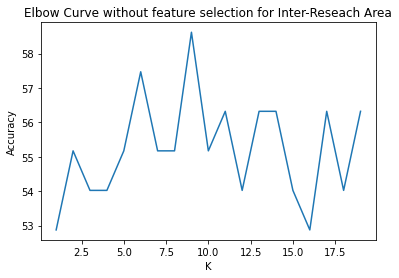


MLP Classifier score is 52.87356321839081%



In [127]:
# fitting logistic regression
lr = LogisticRegression()
lr.fit(features, y_train)
predictionsLR = lr.predict(features2)
scoreLR = accuracy_score(y_test, predictionsLR)
print(f"Logistic Regression score is {scoreLR * 100}% \n")

# fitting SVC
svc = svm.LinearSVC()
svc.fit(features, y_train)
predictionsSVC = svc.predict(features2)
scoreSVC = accuracy_score(y_test, predictionsSVC)
print(f"Support Vector Classifier score is {scoreSVC * 100}%\n")

# fitting decision tree classifier
clf = tree.DecisionTreeClassifier()
clf.fit(features, y_train)
predictionsTree = clf.predict(features2)
scoreTree = accuracy_score(y_test, predictionsTree)
print(f"Decision Tree Classifier score is {scoreTree * 100}%\n")

# fitting Random Forest classifier
clf1 = RandomForestClassifier(max_features=23)
clf1.fit(features, y_train)
predictionsTree1 = clf1.predict(features2)
scoreTree1 = accuracy_score(y_test, predictionsTree1)
print(f"Random Forest Classifier score is {scoreTree1 * 100}%\n")

# fitting XGBoost
# xgb = XGBClassifier()
# xgb.fit(features.to_numpy(), y_train)
# predictionsXGB = xgb.predict(X_test)
# predictionsXGB = (predictionsXGB>0.5).astype(int)
# scoreXGB = accuracy_score(y_test, predictionsXGB)
# print(f"XG Boost Classifier score is {scoreXGB * 100}%\n")

# fitting KNN Classifier
K = range(1, 20)
acc = []
for k in K:
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(features, y_train)
    predictionsKNN = knn.predict(features2)
    scoreKNN = accuracy_score(y_test, predictionsKNN)
    print(f"KNN Classifier score is {scoreKNN * 100}% with k = {k}")
    acc.append(scoreKNN*100)

# Elbow plot:
plt.plot(K, acc)
plt.xlabel('K')
plt.ylabel('Accuracy')
plt.title("Elbow Curve without feature selection for Inter-Reseach Area")

plt.show()

# MLP / ANN
classifier = MLPClassifier(hidden_layer_sizes=(128, 64), max_iter=300, activation='relu', solver='adam', random_state=1)
classifier.fit(features, y_train)
predictionsMLP = classifier.predict(features2)
scoreMLP = accuracy_score(y_test, predictionsMLP)
print(f"\nMLP Classifier score is {scoreMLP * 100}%\n")

In [128]:
from sklearn.naive_bayes import GaussianNB
gnb = GaussianNB()
y_pred = gnb.fit(features, y_train).predict(features2)
print("Number of mislabeled points out of a total %d points : %d"
      % (X_test.shape[0], (y_test != y_pred).sum()))

Number of mislabeled points out of a total 87 points : 40


In [129]:
from numpy import mean
from numpy import std
from sklearn.datasets import make_classification
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from matplotlib import pyplot
# define dataset
# X, y = make_classification(n_samples=1000, n_features=10, n_informative=5, n_redundant=5, random_state=1)
# evaluate the model
# model = GradientBoostingClassifier()
# cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
# n_scores = cross_val_score(model, X_train, y_train, scoring='accuracy', cv=cv, n_jobs=-1, error_score='raise')
# print('Accuracy: %.3f (%.3f)' % (mean(n_scores), std(n_scores)))
# fit the model on the whole dataset
model = GradientBoostingClassifier()
model.fit(features, y_train)
# make a single prediction
# row = [[2.56999479, -0.13019997, 3.16075093, -4.35936352, -1.61271951, -1.39352057, -2.48924933, -1.93094078, 3.26130366, 2.05692145]]
yhat = model.predict(features2)

print(classification_report(yhat,y_test))

              precision    recall  f1-score   support

         0.0       0.82      0.54      0.65        68
         1.0       0.26      0.58      0.36        19

    accuracy                           0.55        87
   macro avg       0.54      0.56      0.51        87
weighted avg       0.70      0.55      0.59        87



In [130]:
# histogram-based gradient boosting for classification in scikit-learn
from numpy import mean
from numpy import std
from sklearn.datasets import make_classification
from sklearn.experimental import enable_hist_gradient_boosting
from sklearn.ensemble import HistGradientBoostingClassifier
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from matplotlib import pyplot
# evaluate the model
# model = HistGradientBoostingClassifier()
# cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
# n_scores = cross_val_score(model, features, y_train, scoring='accuracy', cv=cv, n_jobs=-1, error_score='raise')
# print('Accuracy: %.3f (%.3f)' % (mean(n_scores), std(n_scores)))
# fit the model on the whole dataset
model = HistGradientBoostingClassifier()
model.fit(features, y_train)
# make a single prediction
yhat = model.predict(features2)
print(classification_report(yhat,y_test))

              precision    recall  f1-score   support

         0.0       0.04      1.00      0.09         2
         1.0       1.00      0.49      0.66        85

    accuracy                           0.51        87
   macro avg       0.52      0.75      0.37        87
weighted avg       0.98      0.51      0.65        87



In [131]:
# xgboost for classification
from numpy import asarray
from numpy import mean
from numpy import std
# from sklearn.datasets import make_classification
from xgboost import XGBClassifier
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from matplotlib import pyplot
# define dataset
# X, y = make_classification(n_samples=1000, n_features=10, n_informative=5, n_redundant=5, random_state=1)
# evaluate the model
# model = XGBClassifier()
# cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
# n_scores = cross_val_score(model, features, y_train, scoring='accuracy', cv=cv, n_jobs=-1, error_score='raise')
# print('Accuracy: %.3f (%.3f)' % (mean(n_scores), std(n_scores)))
# fit the model on the whole dataset
model = XGBClassifier()
model.fit(features, y_train)
# make a single prediction
yhat = model.predict(features2)
print(classification_report(yhat,y_test))

[11:27:06] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
              precision    recall  f1-score   support

         0.0       0.87      0.54      0.67        72
         1.0       0.21      0.60      0.32        15

    accuracy                           0.55        87
   macro avg       0.54      0.57      0.49        87
weighted avg       0.75      0.55      0.61        87



In [132]:
# lightgbm for classification
from numpy import mean
from numpy import std
# from sklearn.datasets import make_classification
from lightgbm import LGBMClassifier
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from matplotlib import pyplot
# evaluate the model
# model = LGBMClassifier()
# cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
# n_scores = cross_val_score(model, features, y_train, scoring='accuracy', cv=cv, n_jobs=-1, error_score='raise')
# print('Accuracy: %.3f (%.3f)' % (mean(n_scores), std(n_scores)))
# fit the model on the whole dataset
model = LGBMClassifier()
model.fit(features, y_train)
# make a single prediction
yhat = model.predict(features2)
print(classification_report(yhat,y_test))

              precision    recall  f1-score   support

         0.0       0.07      0.75      0.12         4
         1.0       0.98      0.49      0.66        83

    accuracy                           0.51        87
   macro avg       0.52      0.62      0.39        87
weighted avg       0.93      0.51      0.63        87



# Models rfe features

In [134]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn import svm
from sklearn import tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import StandardScaler
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score
from sklearn.feature_selection import SelectFromModel

from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
%matplotlib inline
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D



import warnings
warnings.filterwarnings('ignore')

In [152]:
features = X_train[rfe_feature]
features2 = X_test[rfe_feature]

In [153]:
features.isna().sum().sum()

0

In [154]:
X_test.isna().sum().sum()

0

In [138]:
from sklearn.model_selection import cross_val_score
# from sklearn.datasets import load_iris
from sklearn.ensemble import AdaBoostClassifier

# X, y = load_iris(return_X_y=True)
clf = AdaBoostClassifier()
# scores = cross_val_score(clf, features, y_train, cv=5)
# print(scores.mean())
clf.fit(features, y_train)
y_pred = (clf.predict(features2)>0.5).astype(int)
from sklearn.metrics import classification_report
print(classification_report(y_pred,y_test))


              precision    recall  f1-score   support

           0       0.64      0.49      0.56        59
           1       0.29      0.43      0.34        28

    accuracy                           0.47        87
   macro avg       0.47      0.46      0.45        87
weighted avg       0.53      0.47      0.49        87



In [139]:
from sklearn.svm import SVC

svclassifier = SVC(gamma='auto')
svclassifier.fit(features, y_train)
y_pred = svclassifier.predict(features2)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

         0.0       0.56      0.64      0.60        45
         1.0       0.54      0.45      0.49        42

    accuracy                           0.55        87
   macro avg       0.55      0.55      0.55        87
weighted avg       0.55      0.55      0.55        87



In [140]:
from sklearn import datasets
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from itertools import product
from sklearn.ensemble import VotingClassifier


clf1 = DecisionTreeClassifier()
clf2 = KNeighborsClassifier()
clf3 = SVC(kernel='rbf', probability=True)
eclf = VotingClassifier(estimators=[('dt', clf1), ('knn', clf2), ('svc', clf3)],
                        voting='soft', weights=[2, 2, 2])

clf1 = clf1.fit(features, y_train)
clf2 = clf2.fit(features, y_train)
clf3 = clf3.fit(features, y_train)
eclf = eclf.fit(features, y_train)

for clf, label in zip([clf1, clf2, clf3, eclf], ['DecisionTreeClassifier', 'KNNClassifier', 'SVC', 'voting']):
    scores = cross_val_score(clf, features, y_train, scoring='accuracy', cv=5)
    print("Accuracy: %0.2f (+/- %0.2f) [%s]" % (scores.mean(), scores.std(), label))

Accuracy: 0.62 (+/- 0.02) [DecisionTreeClassifier]
Accuracy: 0.68 (+/- 0.03) [KNNClassifier]
Accuracy: 0.72 (+/- 0.03) [SVC]
Accuracy: 0.65 (+/- 0.03) [voting]


In [155]:
svc = SVC(kernel='rbf', probability=True)
svc.fit(features, y_train)
predictionsSVC = svc.predict(features2)
scoreSVC = accuracy_score(y_test, predictionsSVC)
print(f"Support Vector Classifier score is {scoreSVC * 100}%\n")
print(classification_report(y_test,predictionsSVC))

Support Vector Classifier score is 55.172413793103445%

              precision    recall  f1-score   support

         0.0       0.56      0.64      0.60        45
         1.0       0.54      0.45      0.49        42

    accuracy                           0.55        87
   macro avg       0.55      0.55      0.55        87
weighted avg       0.55      0.55      0.55        87



Logistic Regression score is 55.172413793103445% 

Support Vector Classifier score is 55.172413793103445%

Decision Tree Classifier score is 51.724137931034484%

Random Forest Classifier score is 48.275862068965516%

KNN Classifier score is 44.827586206896555% with k = 1
KNN Classifier score is 45.97701149425287% with k = 2
KNN Classifier score is 45.97701149425287% with k = 3
KNN Classifier score is 51.724137931034484% with k = 4
KNN Classifier score is 50.57471264367817% with k = 5
KNN Classifier score is 51.724137931034484% with k = 6
KNN Classifier score is 45.97701149425287% with k = 7
KNN Classifier score is 43.67816091954023% with k = 8
KNN Classifier score is 44.827586206896555% with k = 9
KNN Classifier score is 44.827586206896555% with k = 10
KNN Classifier score is 44.827586206896555% with k = 11
KNN Classifier score is 44.827586206896555% with k = 12
KNN Classifier score is 44.827586206896555% with k = 13
KNN Classifier score is 49.42528735632184% with k = 14
KNN Classifier

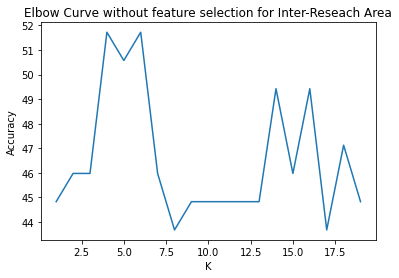


MLP Classifier score is 49.42528735632184%



In [141]:
# fitting logistic regression
lr = LogisticRegression()
lr.fit(features, y_train)
predictionsLR = lr.predict(features2)
scoreLR = accuracy_score(y_test, predictionsLR)
print(f"Logistic Regression score is {scoreLR * 100}% \n")

# fitting SVC
svc = svm.LinearSVC()
svc.fit(features, y_train)
predictionsSVC = svc.predict(features2)
scoreSVC = accuracy_score(y_test, predictionsSVC)
print(f"Support Vector Classifier score is {scoreSVC * 100}%\n")

# fitting decision tree classifier
clf = tree.DecisionTreeClassifier()
clf.fit(features, y_train)
predictionsTree = clf.predict(features2)
scoreTree = accuracy_score(y_test, predictionsTree)
print(f"Decision Tree Classifier score is {scoreTree * 100}%\n")

# fitting Random Forest classifier
clf1 = RandomForestClassifier(max_features=23)
clf1.fit(features, y_train)
predictionsTree1 = clf1.predict(features2)
scoreTree1 = accuracy_score(y_test, predictionsTree1)
print(f"Random Forest Classifier score is {scoreTree1 * 100}%\n")

# fitting XGBoost
# xgb = XGBClassifier()
# xgb.fit(features.to_numpy(), y_train)
# predictionsXGB = xgb.predict(X_test)
# predictionsXGB = (predictionsXGB>0.5).astype(int)
# scoreXGB = accuracy_score(y_test, predictionsXGB)
# print(f"XG Boost Classifier score is {scoreXGB * 100}%\n")

# fitting KNN Classifier
K = range(1, 20)
acc = []
for k in K:
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(features, y_train)
    predictionsKNN = knn.predict(features2)
    scoreKNN = accuracy_score(y_test, predictionsKNN)
    print(f"KNN Classifier score is {scoreKNN * 100}% with k = {k}")
    acc.append(scoreKNN*100)

# Elbow plot:
plt.plot(K, acc)
plt.xlabel('K')
plt.ylabel('Accuracy')
plt.title("Elbow Curve without feature selection for Inter-Reseach Area")

plt.show()

# MLP / ANN
classifier = MLPClassifier(hidden_layer_sizes=(128, 64), max_iter=300, activation='relu', solver='adam', random_state=1)
classifier.fit(features, y_train)
predictionsMLP = classifier.predict(features2)
scoreMLP = accuracy_score(y_test, predictionsMLP)
print(f"\nMLP Classifier score is {scoreMLP * 100}%\n")

In [147]:
from sklearn.naive_bayes import GaussianNB
gnb = GaussianNB()
y_pred = gnb.fit(features, y_train).predict(features2)
print("Number of mislabeled points out of a total %d points : %d"
      % (X_test.shape[0], (y_test != y_pred).sum()))

Number of mislabeled points out of a total 87 points : 38


In [148]:
print(classification_report(y_pred,y_test))

              precision    recall  f1-score   support

         0.0       0.87      0.55      0.67        71
         1.0       0.24      0.62      0.34        16

    accuracy                           0.56        87
   macro avg       0.55      0.59      0.51        87
weighted avg       0.75      0.56      0.61        87



In [143]:
from numpy import mean
from numpy import std
from sklearn.datasets import make_classification
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from matplotlib import pyplot
# define dataset
# X, y = make_classification(n_samples=1000, n_features=10, n_informative=5, n_redundant=5, random_state=1)
# evaluate the model
# model = GradientBoostingClassifier()
# cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
# n_scores = cross_val_score(model, X_train, y_train, scoring='accuracy', cv=cv, n_jobs=-1, error_score='raise')
# print('Accuracy: %.3f (%.3f)' % (mean(n_scores), std(n_scores)))
# fit the model on the whole dataset
model = GradientBoostingClassifier()
model.fit(features, y_train)
# make a single prediction
# row = [[2.56999479, -0.13019997, 3.16075093, -4.35936352, -1.61271951, -1.39352057, -2.48924933, -1.93094078, 3.26130366, 2.05692145]]
yhat = model.predict(features2)

print(classification_report(yhat,y_test))

              precision    recall  f1-score   support

         0.0       0.64      0.57      0.60        51
         1.0       0.48      0.56      0.51        36

    accuracy                           0.56        87
   macro avg       0.56      0.56      0.56        87
weighted avg       0.57      0.56      0.57        87



In [144]:
# histogram-based gradient boosting for classification in scikit-learn
from numpy import mean
from numpy import std
from sklearn.datasets import make_classification
from sklearn.experimental import enable_hist_gradient_boosting
from sklearn.ensemble import HistGradientBoostingClassifier
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from matplotlib import pyplot
# evaluate the model
# model = HistGradientBoostingClassifier()
# cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
# n_scores = cross_val_score(model, features, y_train, scoring='accuracy', cv=cv, n_jobs=-1, error_score='raise')
# print('Accuracy: %.3f (%.3f)' % (mean(n_scores), std(n_scores)))
# fit the model on the whole dataset
model = HistGradientBoostingClassifier()
model.fit(features, y_train)
# make a single prediction
yhat = model.predict(features2)
print(classification_report(yhat,y_test))

              precision    recall  f1-score   support

         0.0       0.58      0.50      0.54        52
         1.0       0.38      0.46      0.42        35

    accuracy                           0.48        87
   macro avg       0.48      0.48      0.48        87
weighted avg       0.50      0.48      0.49        87



In [145]:
# xgboost for classification
from numpy import asarray
from numpy import mean
from numpy import std
from sklearn.datasets import make_classification
from xgboost import XGBClassifier
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from matplotlib import pyplot
# define dataset
X, y = make_classification(n_samples=1000, n_features=10, n_informative=5, n_redundant=5, random_state=1)
# evaluate the model
# model = XGBClassifier()
# cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
# n_scores = cross_val_score(model, features, y_train, scoring='accuracy', cv=cv, n_jobs=-1, error_score='raise')
# print('Accuracy: %.3f (%.3f)' % (mean(n_scores), std(n_scores)))
# fit the model on the whole dataset
model = XGBClassifier()
model.fit(features, y_train)
# make a single prediction
yhat = model.predict(features2)
print(classification_report(yhat,y_test))

[11:27:53] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
              precision    recall  f1-score   support

         0.0       0.56      0.52      0.54        48
         1.0       0.45      0.49      0.47        39

    accuracy                           0.51        87
   macro avg       0.50      0.50      0.50        87
weighted avg       0.51      0.51      0.51        87



In [146]:
# lightgbm for classification
from numpy import mean
from numpy import std
from sklearn.datasets import make_classification
from lightgbm import LGBMClassifier
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from matplotlib import pyplot
# evaluate the model
# model = LGBMClassifier()
# cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
# n_scores = cross_val_score(model, features, y_train, scoring='accuracy', cv=cv, n_jobs=-1, error_score='raise')
# print('Accuracy: %.3f (%.3f)' % (mean(n_scores), std(n_scores)))
# fit the model on the whole dataset
model = LGBMClassifier()
model.fit(features, y_train)
# make a single prediction
yhat = model.predict(features2)
print(classification_report(yhat,y_test))

              precision    recall  f1-score   support

         0.0       0.56      0.48      0.52        52
         1.0       0.36      0.43      0.39        35

    accuracy                           0.46        87
   macro avg       0.46      0.45      0.45        87
weighted avg       0.48      0.46      0.46        87



# Models embed

In [ ]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn import svm
from sklearn import tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import StandardScaler
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score
from sklearn.feature_selection import SelectFromModel

from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
%matplotlib inline
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D



import warnings
warnings.filterwarnings('ignore')

In [138]:
features = X_train[embeded_lr_feature]
features2 = X_test[embeded_lr_feature]

In [139]:
features.isna().sum().sum()

0

In [140]:
X_test.isna().sum().sum()

0

In [141]:
from sklearn.model_selection import cross_val_score
# from sklearn.datasets import load_iris
from sklearn.ensemble import AdaBoostClassifier

# X, y = load_iris(return_X_y=True)
clf = AdaBoostClassifier()
# scores = cross_val_score(clf, features, y_train, cv=5)
# print(scores.mean())
clf.fit(features, y_train)
y_pred = (clf.predict(features2)>0.5).astype(int)
from sklearn.metrics import classification_report
print(classification_report(y_pred,y_test))


              precision    recall  f1-score   support

           0       0.31      0.52      0.39        27
           1       0.69      0.48      0.57        60

    accuracy                           0.49        87
   macro avg       0.50      0.50      0.48        87
weighted avg       0.57      0.49      0.51        87



In [142]:
from sklearn.svm import SVC

svclassifier = SVC(gamma='auto')
svclassifier.fit(features, y_train)
y_pred = svclassifier.predict(features2)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.53      0.20      0.29        45
           1       0.49      0.81      0.61        42

    accuracy                           0.49        87
   macro avg       0.51      0.50      0.45        87
weighted avg       0.51      0.49      0.44        87



In [143]:
from sklearn import datasets
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from itertools import product
from sklearn.ensemble import VotingClassifier


clf1 = DecisionTreeClassifier()
clf2 = KNeighborsClassifier()
clf3 = SVC(kernel='rbf', probability=True)
eclf = VotingClassifier(estimators=[('dt', clf1), ('knn', clf2), ('svc', clf3)],
                        voting='soft', weights=[2, 2, 2])

clf1 = clf1.fit(features, y_train)
clf2 = clf2.fit(features, y_train)
clf3 = clf3.fit(features, y_train)
eclf = eclf.fit(features, y_train)

for clf, label in zip([clf1, clf2, clf3, eclf], ['DecisionTreeClassifier', 'KNNClassifier', 'SVC', 'voting']):
    scores = cross_val_score(clf, features, y_train, scoring='accuracy', cv=5)
    print("Accuracy: %0.2f (+/- %0.2f) [%s]" % (scores.mean(), scores.std(), label))

Accuracy: 0.51 (+/- 0.04) [DecisionTreeClassifier]
Accuracy: 0.54 (+/- 0.01) [KNNClassifier]
Accuracy: 0.59 (+/- 0.02) [SVC]
Accuracy: 0.53 (+/- 0.04) [voting]


Logistic Regression score is 56.32183908045977% 

Support Vector Classifier score is 55.172413793103445%

Decision Tree Classifier score is 47.12643678160919%

Random Forest Classifier score is 48.275862068965516%

KNN Classifier score is 48.275862068965516% with k = 1
KNN Classifier score is 49.42528735632184% with k = 2
KNN Classifier score is 44.827586206896555% with k = 3
KNN Classifier score is 42.5287356321839% with k = 4
KNN Classifier score is 45.97701149425287% with k = 5
KNN Classifier score is 42.5287356321839% with k = 6
KNN Classifier score is 51.724137931034484% with k = 7
KNN Classifier score is 49.42528735632184% with k = 8
KNN Classifier score is 49.42528735632184% with k = 9
KNN Classifier score is 51.724137931034484% with k = 10
KNN Classifier score is 50.57471264367817% with k = 11
KNN Classifier score is 44.827586206896555% with k = 12
KNN Classifier score is 45.97701149425287% with k = 13
KNN Classifier score is 48.275862068965516% with k = 14
KNN Classifier score

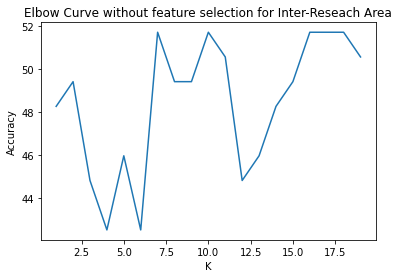


MLP Classifier score is 50.57471264367817%



In [144]:
# fitting logistic regression
lr = LogisticRegression()
lr.fit(features, y_train)
predictionsLR = lr.predict(features2)
scoreLR = accuracy_score(y_test, predictionsLR)
print(f"Logistic Regression score is {scoreLR * 100}% \n")

# fitting SVC
svc = svm.LinearSVC()
svc.fit(features, y_train)
predictionsSVC = svc.predict(features2)
scoreSVC = accuracy_score(y_test, predictionsSVC)
print(f"Support Vector Classifier score is {scoreSVC * 100}%\n")

# fitting decision tree classifier
clf = tree.DecisionTreeClassifier()
clf.fit(features, y_train)
predictionsTree = clf.predict(features2)
scoreTree = accuracy_score(y_test, predictionsTree)
print(f"Decision Tree Classifier score is {scoreTree * 100}%\n")

# fitting Random Forest classifier
clf1 = RandomForestClassifier(max_features=23)
clf1.fit(features, y_train)
predictionsTree1 = clf1.predict(features2)
scoreTree1 = accuracy_score(y_test, predictionsTree1)
print(f"Random Forest Classifier score is {scoreTree1 * 100}%\n")

# fitting XGBoost
# xgb = XGBClassifier()
# xgb.fit(features.to_numpy(), y_train)
# predictionsXGB = xgb.predict(X_test)
# predictionsXGB = (predictionsXGB>0.5).astype(int)
# scoreXGB = accuracy_score(y_test, predictionsXGB)
# print(f"XG Boost Classifier score is {scoreXGB * 100}%\n")

# fitting KNN Classifier
K = range(1, 20)
acc = []
for k in K:
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(features, y_train)
    predictionsKNN = knn.predict(features2)
    scoreKNN = accuracy_score(y_test, predictionsKNN)
    print(f"KNN Classifier score is {scoreKNN * 100}% with k = {k}")
    acc.append(scoreKNN*100)

# Elbow plot:
plt.plot(K, acc)
plt.xlabel('K')
plt.ylabel('Accuracy')
plt.title("Elbow Curve without feature selection for Inter-Reseach Area")

plt.show()

# MLP / ANN
classifier = MLPClassifier(hidden_layer_sizes=(128, 64), max_iter=300, activation='relu', solver='adam', random_state=1)
classifier.fit(features, y_train)
predictionsMLP = classifier.predict(features2)
scoreMLP = accuracy_score(y_test, predictionsMLP)
print(f"\nMLP Classifier score is {scoreMLP * 100}%\n")

In [145]:
from sklearn.naive_bayes import GaussianNB
gnb = GaussianNB()
y_pred = gnb.fit(features, y_train).predict(features2)
print("Number of mislabeled points out of a total %d points : %d"
      % (X_test.shape[0], (y_test != y_pred).sum()))

Number of mislabeled points out of a total 87 points : 44


In [146]:
from numpy import mean
from numpy import std
from sklearn.datasets import make_classification
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from matplotlib import pyplot
# define dataset
# X, y = make_classification(n_samples=1000, n_features=10, n_informative=5, n_redundant=5, random_state=1)
# evaluate the model
# model = GradientBoostingClassifier()
# cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
# n_scores = cross_val_score(model, X_train, y_train, scoring='accuracy', cv=cv, n_jobs=-1, error_score='raise')
# print('Accuracy: %.3f (%.3f)' % (mean(n_scores), std(n_scores)))
# fit the model on the whole dataset
model = GradientBoostingClassifier()
model.fit(features, y_train)
# make a single prediction
# row = [[2.56999479, -0.13019997, 3.16075093, -4.35936352, -1.61271951, -1.39352057, -2.48924933, -1.93094078, 3.26130366, 2.05692145]]
yhat = model.predict(features2)

print(classification_report(yhat,y_test))

              precision    recall  f1-score   support

           0       0.29      0.52      0.37        25
           1       0.71      0.48      0.58        62

    accuracy                           0.49        87
   macro avg       0.50      0.50      0.47        87
weighted avg       0.59      0.49      0.52        87



In [147]:
# histogram-based gradient boosting for classification in scikit-learn
from numpy import mean
from numpy import std
from sklearn.datasets import make_classification
from sklearn.experimental import enable_hist_gradient_boosting
from sklearn.ensemble import HistGradientBoostingClassifier
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from matplotlib import pyplot
# evaluate the model
# model = HistGradientBoostingClassifier()
# cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
# n_scores = cross_val_score(model, features, y_train, scoring='accuracy', cv=cv, n_jobs=-1, error_score='raise')
# print('Accuracy: %.3f (%.3f)' % (mean(n_scores), std(n_scores)))
# fit the model on the whole dataset
model = HistGradientBoostingClassifier()
model.fit(features, y_train)
# make a single prediction
yhat = model.predict(features2)
print(classification_report(yhat,y_test))

              precision    recall  f1-score   support

           0       0.27      0.60      0.37        20
           1       0.81      0.51      0.62        67

    accuracy                           0.53        87
   macro avg       0.54      0.55      0.50        87
weighted avg       0.68      0.53      0.57        87



In [ ]:
# xgboost for classification
from numpy import asarray
from numpy import mean
from numpy import std
from sklearn.datasets import make_classification
from xgboost import XGBClassifier
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from matplotlib import pyplot
# define dataset
X, y = make_classification(n_samples=1000, n_features=10, n_informative=5, n_redundant=5, random_state=1)
# evaluate the model
# model = XGBClassifier()
# cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
# n_scores = cross_val_score(model, features, y_train, scoring='accuracy', cv=cv, n_jobs=-1, error_score='raise')
# print('Accuracy: %.3f (%.3f)' % (mean(n_scores), std(n_scores)))
# fit the model on the whole dataset
model = XGBClassifier()
model.fit(features, y_train)
# make a single prediction
yhat = model.predict(features2)
print(classification_report(yhat,y_test))

ValueError: ignored

In [148]:
# lightgbm for classification
from numpy import mean
from numpy import std
from sklearn.datasets import make_classification
from lightgbm import LGBMClassifier
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from matplotlib import pyplot
# evaluate the model
# model = LGBMClassifier()
# cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
# n_scores = cross_val_score(model, features, y_train, scoring='accuracy', cv=cv, n_jobs=-1, error_score='raise')
# print('Accuracy: %.3f (%.3f)' % (mean(n_scores), std(n_scores)))
# fit the model on the whole dataset
model = LGBMClassifier()
model.fit(features, y_train)
# make a single prediction
yhat = model.predict(features2)
print(classification_report(yhat,y_test))

              precision    recall  f1-score   support

           0       0.24      0.65      0.35        17
           1       0.86      0.51      0.64        70

    accuracy                           0.54        87
   macro avg       0.55      0.58      0.50        87
weighted avg       0.74      0.54      0.59        87



# Models embed rf

In [18]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn import svm
from sklearn import tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import StandardScaler
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score
from sklearn.feature_selection import SelectFromModel

from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
%matplotlib inline
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D



import warnings
warnings.filterwarnings('ignore')

In [23]:
from sklearn.metrics import classification_report, confusion_matrix

In [19]:
features = X_train[embeded_rf_feature]
features2 = X_test[embeded_rf_feature]

In [20]:
features.isna().sum().sum()

0

In [21]:
X_test.isna().sum().sum()

0

In [24]:
from sklearn.model_selection import cross_val_score
# from sklearn.datasets import load_iris
from sklearn.ensemble import AdaBoostClassifier

# X, y = load_iris(return_X_y=True)
clf = AdaBoostClassifier()
# scores = cross_val_score(clf, features, y_train, cv=5)
# print(scores.mean())
clf.fit(features, y_train)
y_pred = (clf.predict(features2)>0.5).astype(int)
from sklearn.metrics import classification_report
print(classification_report(y_pred,y_test))


              precision    recall  f1-score   support

           0       0.22      0.42      0.29        24
           1       0.67      0.44      0.53        63

    accuracy                           0.44        87
   macro avg       0.44      0.43      0.41        87
weighted avg       0.54      0.44      0.47        87



In [25]:
from sklearn.svm import SVC

svclassifier = SVC(gamma='auto')
svclassifier.fit(features, y_train)
y_pred = svclassifier.predict(features2)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.47      0.20      0.28        45
           1       0.47      0.76      0.58        42

    accuracy                           0.47        87
   macro avg       0.47      0.48      0.43        87
weighted avg       0.47      0.47      0.43        87



In [26]:
from sklearn import datasets
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from itertools import product
from sklearn.ensemble import VotingClassifier


clf1 = DecisionTreeClassifier()
clf2 = KNeighborsClassifier()
clf3 = SVC(kernel='rbf', probability=True)
eclf = VotingClassifier(estimators=[('dt', clf1), ('knn', clf2), ('svc', clf3)],
                        voting='soft', weights=[2, 2, 2])

clf1 = clf1.fit(features, y_train)
clf2 = clf2.fit(features, y_train)
clf3 = clf3.fit(features, y_train)
eclf = eclf.fit(features, y_train)

for clf, label in zip([clf1, clf2, clf3, eclf], ['DecisionTreeClassifier', 'KNNClassifier', 'SVC', 'voting']):
    scores = cross_val_score(clf, features, y_train, scoring='accuracy', cv=5)
    print("Accuracy: %0.2f (+/- %0.2f) [%s]" % (scores.mean(), scores.std(), label))

Accuracy: 0.51 (+/- 0.01) [DecisionTreeClassifier]
Accuracy: 0.52 (+/- 0.03) [KNNClassifier]
Accuracy: 0.55 (+/- 0.02) [SVC]
Accuracy: 0.53 (+/- 0.04) [voting]


Logistic Regression score is 49.42528735632184% 

Support Vector Classifier score is 52.87356321839081%

Decision Tree Classifier score is 47.12643678160919%

Random Forest Classifier score is 51.724137931034484%

KNN Classifier score is 47.12643678160919% with k = 1
KNN Classifier score is 44.827586206896555% with k = 2
KNN Classifier score is 47.12643678160919% with k = 3
KNN Classifier score is 47.12643678160919% with k = 4
KNN Classifier score is 50.57471264367817% with k = 5
KNN Classifier score is 45.97701149425287% with k = 6
KNN Classifier score is 52.87356321839081% with k = 7
KNN Classifier score is 51.724137931034484% with k = 8
KNN Classifier score is 54.02298850574713% with k = 9
KNN Classifier score is 52.87356321839081% with k = 10
KNN Classifier score is 51.724137931034484% with k = 11
KNN Classifier score is 51.724137931034484% with k = 12
KNN Classifier score is 54.02298850574713% with k = 13
KNN Classifier score is 54.02298850574713% with k = 14
KNN Classifier score 

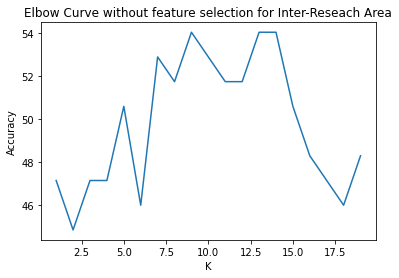


MLP Classifier score is 47.12643678160919%



In [27]:
# fitting logistic regression
lr = LogisticRegression()
lr.fit(features, y_train)
predictionsLR = lr.predict(features2)
scoreLR = accuracy_score(y_test, predictionsLR)
print(f"Logistic Regression score is {scoreLR * 100}% \n")

# fitting SVC
svc = svm.LinearSVC()
svc.fit(features, y_train)
predictionsSVC = svc.predict(features2)
scoreSVC = accuracy_score(y_test, predictionsSVC)
print(f"Support Vector Classifier score is {scoreSVC * 100}%\n")

# fitting decision tree classifier
clf = tree.DecisionTreeClassifier()
clf.fit(features, y_train)
predictionsTree = clf.predict(features2)
scoreTree = accuracy_score(y_test, predictionsTree)
print(f"Decision Tree Classifier score is {scoreTree * 100}%\n")

# fitting Random Forest classifier
clf1 = RandomForestClassifier(max_features=23)
clf1.fit(features, y_train)
predictionsTree1 = clf1.predict(features2)
scoreTree1 = accuracy_score(y_test, predictionsTree1)
print(f"Random Forest Classifier score is {scoreTree1 * 100}%\n")

# fitting XGBoost
# xgb = XGBClassifier()
# xgb.fit(features.to_numpy(), y_train)
# predictionsXGB = xgb.predict(X_test)
# predictionsXGB = (predictionsXGB>0.5).astype(int)
# scoreXGB = accuracy_score(y_test, predictionsXGB)
# print(f"XG Boost Classifier score is {scoreXGB * 100}%\n")

# fitting KNN Classifier
K = range(1, 20)
acc = []
for k in K:
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(features, y_train)
    predictionsKNN = knn.predict(features2)
    scoreKNN = accuracy_score(y_test, predictionsKNN)
    print(f"KNN Classifier score is {scoreKNN * 100}% with k = {k}")
    acc.append(scoreKNN*100)

# Elbow plot:
plt.plot(K, acc)
plt.xlabel('K')
plt.ylabel('Accuracy')
plt.title("Elbow Curve without feature selection for Inter-Reseach Area")

plt.show()

# MLP / ANN
classifier = MLPClassifier(hidden_layer_sizes=(128, 64), max_iter=300, activation='relu', solver='adam', random_state=1)
classifier.fit(features, y_train)
predictionsMLP = classifier.predict(features2)
scoreMLP = accuracy_score(y_test, predictionsMLP)
print(f"\nMLP Classifier score is {scoreMLP * 100}%\n")

In [30]:
from sklearn.naive_bayes import GaussianNB
gnb = GaussianNB()
y_pred = gnb.fit(features, y_train).predict(features2)
print("Number of mislabeled points out of a total %d points : %d"
      % (X_test.shape[0], (y_test != y_pred).sum()))

print(classification_report(y_test,y_pred))

Number of mislabeled points out of a total 87 points : 48
              precision    recall  f1-score   support

           0       0.47      0.58      0.52        45
           1       0.41      0.31      0.35        42

    accuracy                           0.45        87
   macro avg       0.44      0.44      0.44        87
weighted avg       0.44      0.45      0.44        87



In [29]:
from numpy import mean
from numpy import std
# from sklearn.datasets import make_classification
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from matplotlib import pyplot
# define dataset
# X, y = make_classification(n_samples=1000, n_features=10, n_informative=5, n_redundant=5, random_state=1)
# evaluate the model
# model = GradientBoostingClassifier()
# cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
# n_scores = cross_val_score(model, X_train, y_train, scoring='accuracy', cv=cv, n_jobs=-1, error_score='raise')
# print('Accuracy: %.3f (%.3f)' % (mean(n_scores), std(n_scores)))
# fit the model on the whole dataset
model = GradientBoostingClassifier()
model.fit(features, y_train)
# make a single prediction
# row = [[2.56999479, -0.13019997, 3.16075093, -4.35936352, -1.61271951, -1.39352057, -2.48924933, -1.93094078, 3.26130366, 2.05692145]]
yhat = model.predict(features2)

print(classification_report(yhat,y_test))

              precision    recall  f1-score   support

           0       0.33      0.56      0.42        27
           1       0.71      0.50      0.59        60

    accuracy                           0.52        87
   macro avg       0.52      0.53      0.50        87
weighted avg       0.60      0.52      0.53        87



In [31]:
# histogram-based gradient boosting for classification in scikit-learn
from numpy import mean
from numpy import std
from sklearn.datasets import make_classification
from sklearn.experimental import enable_hist_gradient_boosting
from sklearn.ensemble import HistGradientBoostingClassifier
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from matplotlib import pyplot
# evaluate the model
# model = HistGradientBoostingClassifier()
# cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
# n_scores = cross_val_score(model, features, y_train, scoring='accuracy', cv=cv, n_jobs=-1, error_score='raise')
# print('Accuracy: %.3f (%.3f)' % (mean(n_scores), std(n_scores)))
# fit the model on the whole dataset
model = HistGradientBoostingClassifier()
model.fit(features, y_train)
# make a single prediction
yhat = model.predict(features2)
print(classification_report(yhat,y_test))

              precision    recall  f1-score   support

           0       0.16      0.54      0.24        13
           1       0.86      0.49      0.62        74

    accuracy                           0.49        87
   macro avg       0.51      0.51      0.43        87
weighted avg       0.75      0.49      0.56        87



In [32]:
# xgboost for classification
from numpy import asarray
from numpy import mean
from numpy import std
# from sklearn.datasets import make_classification
from xgboost import XGBClassifier
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from matplotlib import pyplot
# define dataset
# X, y = make_classification(n_samples=1000, n_features=10, n_informative=5, n_redundant=5, random_state=1)
# evaluate the model
# model = XGBClassifier()
# cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
# n_scores = cross_val_score(model, features, y_train, scoring='accuracy', cv=cv, n_jobs=-1, error_score='raise')
# print('Accuracy: %.3f (%.3f)' % (mean(n_scores), std(n_scores)))
# fit the model on the whole dataset
model = XGBClassifier()
model.fit(features, y_train)
# make a single prediction
yhat = model.predict(features2)
print(classification_report(yhat,y_test))

ValueError: ignored

In [33]:
# lightgbm for classification
from numpy import mean
from numpy import std
from sklearn.datasets import make_classification
from lightgbm import LGBMClassifier
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from matplotlib import pyplot
# evaluate the model
# model = LGBMClassifier()
# cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
# n_scores = cross_val_score(model, features, y_train, scoring='accuracy', cv=cv, n_jobs=-1, error_score='raise')
# print('Accuracy: %.3f (%.3f)' % (mean(n_scores), std(n_scores)))
# fit the model on the whole dataset
model = LGBMClassifier()
model.fit(features, y_train)
# make a single prediction
yhat = model.predict(features2)
print(classification_report(yhat,y_test))

              precision    recall  f1-score   support

           0       0.33      0.58      0.42        26
           1       0.74      0.51      0.60        61

    accuracy                           0.53        87
   macro avg       0.54      0.54      0.51        87
weighted avg       0.62      0.53      0.55        87



# Models lgbm

In [ ]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn import svm
from sklearn import tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import StandardScaler
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score
from sklearn.feature_selection import SelectFromModel

from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
%matplotlib inline
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D



import warnings
warnings.filterwarnings('ignore')

In [ ]:
features = X_train[embeded_lgb_feature]
features2 = X_test[embeded_lgb_feature]

In [ ]:
features.isna().sum().sum()

0

In [ ]:
X_test.isna().sum().sum()

0

In [ ]:
from sklearn.model_selection import cross_val_score
# from sklearn.datasets import load_iris
from sklearn.ensemble import AdaBoostClassifier

# X, y = load_iris(return_X_y=True)
clf = AdaBoostClassifier()
# scores = cross_val_score(clf, features, y_train, cv=5)
# print(scores.mean())
clf.fit(features, y_train)
y_pred = (clf.predict(features2)>0.5).astype(int)
from sklearn.metrics import classification_report
print(classification_report(y_pred,y_test))


              precision    recall  f1-score   support

           0       0.31      0.52      0.39        27
           1       0.69      0.48      0.57        60

    accuracy                           0.49        87
   macro avg       0.50      0.50      0.48        87
weighted avg       0.57      0.49      0.51        87



In [ ]:
from sklearn.svm import SVC

svclassifier = SVC(gamma='auto')
svclassifier.fit(features, y_train)
y_pred = svclassifier.predict(features2)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.53      0.20      0.29        45
           1       0.49      0.81      0.61        42

    accuracy                           0.49        87
   macro avg       0.51      0.50      0.45        87
weighted avg       0.51      0.49      0.44        87



In [ ]:
from sklearn import datasets
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from itertools import product
from sklearn.ensemble import VotingClassifier


clf1 = DecisionTreeClassifier()
clf2 = KNeighborsClassifier()
clf3 = SVC(kernel='rbf', probability=True)
eclf = VotingClassifier(estimators=[('dt', clf1), ('knn', clf2), ('svc', clf3)],
                        voting='soft', weights=[2, 2, 2])

clf1 = clf1.fit(features, y_train)
clf2 = clf2.fit(features, y_train)
clf3 = clf3.fit(features, y_train)
eclf = eclf.fit(features, y_train)

for clf, label in zip([clf1, clf2, clf3, eclf], ['DecisionTreeClassifier', 'KNNClassifier', 'SVC', 'voting']):
    scores = cross_val_score(clf, features, y_train, scoring='accuracy', cv=5)
    print("Accuracy: %0.2f (+/- %0.2f) [%s]" % (scores.mean(), scores.std(), label))

Accuracy: 0.51 (+/- 0.04) [DecisionTreeClassifier]
Accuracy: 0.54 (+/- 0.01) [KNNClassifier]
Accuracy: 0.59 (+/- 0.02) [SVC]
Accuracy: 0.53 (+/- 0.04) [voting]


Logistic Regression score is 56.32183908045977% 

Support Vector Classifier score is 55.172413793103445%

Decision Tree Classifier score is 47.12643678160919%

Random Forest Classifier score is 48.275862068965516%

KNN Classifier score is 48.275862068965516% with k = 1
KNN Classifier score is 49.42528735632184% with k = 2
KNN Classifier score is 44.827586206896555% with k = 3
KNN Classifier score is 42.5287356321839% with k = 4
KNN Classifier score is 45.97701149425287% with k = 5
KNN Classifier score is 42.5287356321839% with k = 6
KNN Classifier score is 51.724137931034484% with k = 7
KNN Classifier score is 49.42528735632184% with k = 8
KNN Classifier score is 49.42528735632184% with k = 9
KNN Classifier score is 51.724137931034484% with k = 10
KNN Classifier score is 50.57471264367817% with k = 11
KNN Classifier score is 44.827586206896555% with k = 12
KNN Classifier score is 45.97701149425287% with k = 13
KNN Classifier score is 48.275862068965516% with k = 14
KNN Classifier score

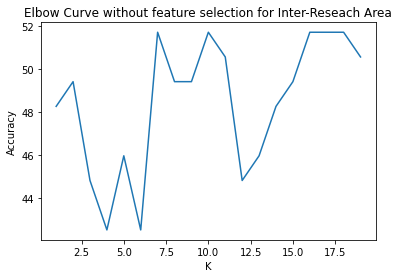


MLP Classifier score is 50.57471264367817%



In [ ]:
# fitting logistic regression
lr = LogisticRegression()
lr.fit(features, y_train)
predictionsLR = lr.predict(features2)
scoreLR = accuracy_score(y_test, predictionsLR)
print(f"Logistic Regression score is {scoreLR * 100}% \n")

# fitting SVC
svc = svm.LinearSVC()
svc.fit(features, y_train)
predictionsSVC = svc.predict(features2)
scoreSVC = accuracy_score(y_test, predictionsSVC)
print(f"Support Vector Classifier score is {scoreSVC * 100}%\n")

# fitting decision tree classifier
clf = tree.DecisionTreeClassifier()
clf.fit(features, y_train)
predictionsTree = clf.predict(features2)
scoreTree = accuracy_score(y_test, predictionsTree)
print(f"Decision Tree Classifier score is {scoreTree * 100}%\n")

# fitting Random Forest classifier
clf1 = RandomForestClassifier(max_features=23)
clf1.fit(features, y_train)
predictionsTree1 = clf1.predict(features2)
scoreTree1 = accuracy_score(y_test, predictionsTree1)
print(f"Random Forest Classifier score is {scoreTree1 * 100}%\n")

# fitting XGBoost
# xgb = XGBClassifier()
# xgb.fit(features.to_numpy(), y_train)
# predictionsXGB = xgb.predict(X_test)
# predictionsXGB = (predictionsXGB>0.5).astype(int)
# scoreXGB = accuracy_score(y_test, predictionsXGB)
# print(f"XG Boost Classifier score is {scoreXGB * 100}%\n")

# fitting KNN Classifier
K = range(1, 20)
acc = []
for k in K:
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(features, y_train)
    predictionsKNN = knn.predict(features2)
    scoreKNN = accuracy_score(y_test, predictionsKNN)
    print(f"KNN Classifier score is {scoreKNN * 100}% with k = {k}")
    acc.append(scoreKNN*100)

# Elbow plot:
plt.plot(K, acc)
plt.xlabel('K')
plt.ylabel('Accuracy')
plt.title("Elbow Curve without feature selection for Inter-Reseach Area")

plt.show()

# MLP / ANN
classifier = MLPClassifier(hidden_layer_sizes=(128, 64), max_iter=300, activation='relu', solver='adam', random_state=1)
classifier.fit(features, y_train)
predictionsMLP = classifier.predict(features2)
scoreMLP = accuracy_score(y_test, predictionsMLP)
print(f"\nMLP Classifier score is {scoreMLP * 100}%\n")

In [ ]:
from sklearn.naive_bayes import GaussianNB
gnb = GaussianNB()
y_pred = gnb.fit(features, y_train).predict(features2)
print("Number of mislabeled points out of a total %d points : %d"
      % (X_test.shape[0], (y_test != y_pred).sum()))

Number of mislabeled points out of a total 87 points : 44


In [ ]:
from numpy import mean
from numpy import std
from sklearn.datasets import make_classification
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from matplotlib import pyplot
# define dataset
# X, y = make_classification(n_samples=1000, n_features=10, n_informative=5, n_redundant=5, random_state=1)
# evaluate the model
# model = GradientBoostingClassifier()
# cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
# n_scores = cross_val_score(model, X_train, y_train, scoring='accuracy', cv=cv, n_jobs=-1, error_score='raise')
# print('Accuracy: %.3f (%.3f)' % (mean(n_scores), std(n_scores)))
# fit the model on the whole dataset
model = GradientBoostingClassifier()
model.fit(features, y_train)
# make a single prediction
# row = [[2.56999479, -0.13019997, 3.16075093, -4.35936352, -1.61271951, -1.39352057, -2.48924933, -1.93094078, 3.26130366, 2.05692145]]
yhat = model.predict(features2)

print(classification_report(yhat,y_test))

              precision    recall  f1-score   support

           0       0.29      0.52      0.37        25
           1       0.71      0.48      0.58        62

    accuracy                           0.49        87
   macro avg       0.50      0.50      0.47        87
weighted avg       0.59      0.49      0.52        87



In [ ]:
# histogram-based gradient boosting for classification in scikit-learn
from numpy import mean
from numpy import std
from sklearn.datasets import make_classification
from sklearn.experimental import enable_hist_gradient_boosting
from sklearn.ensemble import HistGradientBoostingClassifier
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from matplotlib import pyplot
# evaluate the model
# model = HistGradientBoostingClassifier()
# cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
# n_scores = cross_val_score(model, features, y_train, scoring='accuracy', cv=cv, n_jobs=-1, error_score='raise')
# print('Accuracy: %.3f (%.3f)' % (mean(n_scores), std(n_scores)))
# fit the model on the whole dataset
model = HistGradientBoostingClassifier()
model.fit(features, y_train)
# make a single prediction
yhat = model.predict(features2)
print(classification_report(yhat,y_test))

              precision    recall  f1-score   support

           0       0.27      0.60      0.37        20
           1       0.81      0.51      0.62        67

    accuracy                           0.53        87
   macro avg       0.54      0.55      0.50        87
weighted avg       0.68      0.53      0.57        87



In [118]:
# xgboost for classification
from numpy import asarray
from numpy import mean
from numpy import std
from sklearn.datasets import make_classification
from xgboost import XGBClassifier
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from matplotlib import pyplot
# define dataset
# X, y = make_classification(n_samples=1000, n_features=10, n_informative=5, n_redundant=5, random_state=1)
# evaluate the model
# model = XGBClassifier()
# cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
# n_scores = cross_val_score(model, features, y_train, scoring='accuracy', cv=cv, n_jobs=-1, error_score='raise')
# print('Accuracy: %.3f (%.3f)' % (mean(n_scores), std(n_scores)))
# fit the model on the whole dataset
model = XGBClassifier()
model.fit(features, y_train)
# make a single prediction
yhat = model.predict(features2)
print(classification_report(yhat,y_test))

[11:25:38] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
              precision    recall  f1-score   support

         0.0       0.87      0.54      0.67        72
         1.0       0.21      0.60      0.32        15

    accuracy                           0.55        87
   macro avg       0.54      0.57      0.49        87
weighted avg       0.75      0.55      0.61        87



In [ ]:
# lightgbm for classification
from numpy import mean
from numpy import std
from sklearn.datasets import make_classification
from lightgbm import LGBMClassifier
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from matplotlib import pyplot
# evaluate the model
# model = LGBMClassifier()
# cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
# n_scores = cross_val_score(model, features, y_train, scoring='accuracy', cv=cv, n_jobs=-1, error_score='raise')
# print('Accuracy: %.3f (%.3f)' % (mean(n_scores), std(n_scores)))
# fit the model on the whole dataset
model = LGBMClassifier()
model.fit(features, y_train)
# make a single prediction
yhat = model.predict(features2)
print(classification_report(yhat,y_test))

              precision    recall  f1-score   support

           0       0.24      0.65      0.35        17
           1       0.86      0.51      0.64        70

    accuracy                           0.54        87
   macro avg       0.55      0.58      0.50        87
weighted avg       0.74      0.54      0.59        87

